In [153]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin

In [154]:
def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100):

    key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        E = (pdf*pdf.columns.values[np.newaxis, :] / pdf.sum(1).values[:, np.newaxis]).sum(1)

        E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels)],
        names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).to_frame('E')

        return E
    else:
        print(pdf)
        return pd.DataFrame(np.zeros((0, 0)))

In [155]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPC12r', 'NPCr', 'NPCl']
n_voxels = [50, 100, 250]

pred = []
for (sub, session, pcac, den, smooth, mask, nv) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels):
    pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv))

  0%|          | 0/945 [00:00<?, ?it/s]

/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.denoise/sub-04/func/sub-04_ses-1_mask-NPCr_nvoxels-100_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.denoise/sub-04/func/sub-04_ses-1_mask-NPCl_nvoxels-250_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.denoise/sub-04/func/sub-04_ses-2_mask-NPCr_nvoxels-100_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.denoise/sub-04/func/sub-04_ses-2_mask-NPCr_nvoxels-250_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.denoise/sub-04/func/sub-04_ses-2_mask-NPCl_nvoxels-100_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.denoise/sub-04/func/sub-04_ses-2_mask-NPCl_nvoxels-250_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.denoise/sub-04/func/sub-04_ses-3_mask-NPCr_nvoxels-50_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.denoise/sub-04/func/sub-04_ses-3_mask-NPCr_nvoxels-100_space-T1w_pars.tsv
/data/ds-tmsrisk/

In [156]:
df = get_all_behavior(drop_no_responses=False)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:66: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:41: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)


In [157]:
pred = pd.concat(pred)

In [158]:
pred = pred.join(df, how='inner')

In [159]:
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_37538/2590181517.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [160]:
tmp = r2.droplevel('stimulation_condition')['n'].unstack('mask').unstack('n_voxels')

tmp[tmp.isnull().any(1)].iloc[:50]

tmp[tmp.isnull().any(1)].index.unique('subject').tolist()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_37538/631064223.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp[tmp.isnull().any(1)].iloc[:50]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_37538/631064223.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tmp[tmp.isnull().any(1)].index.unique('subject').tolist()


[4, 5, 6, 7, 9, 31]

In [161]:
import seaborn as sns

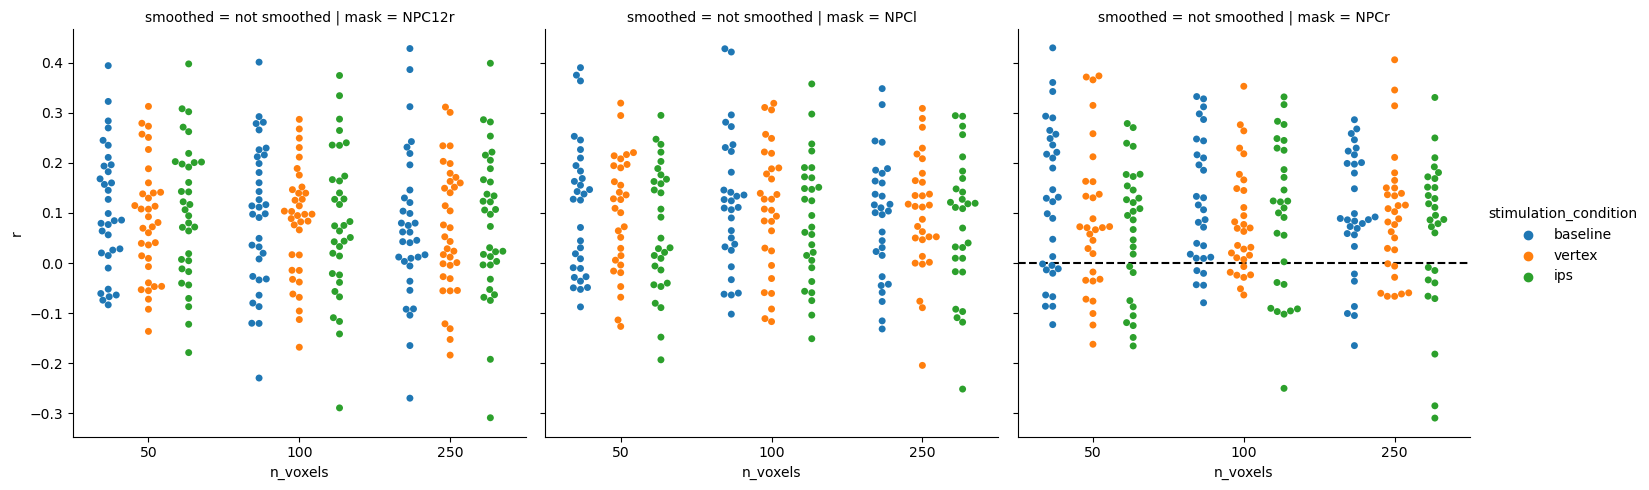

In [162]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r1.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)
plt.axhline(0, c='k', ls='--')

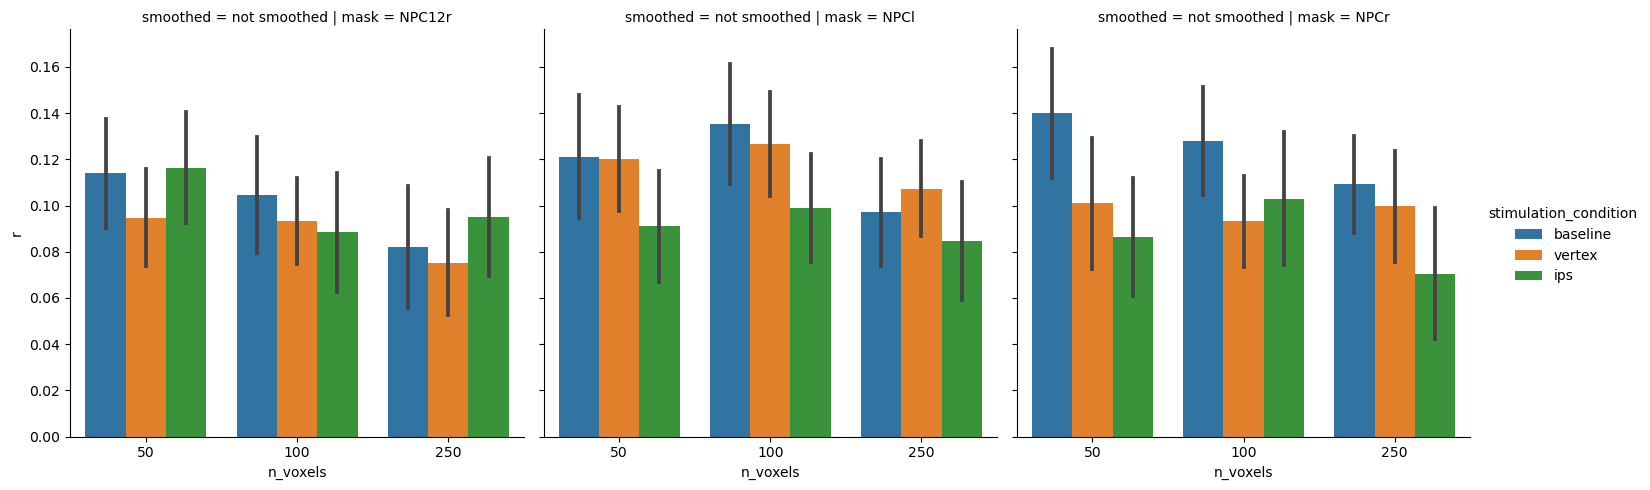

In [163]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, errorbar='se')

In [166]:
r2.sort_values('r')

n  \
subject session stimulation_condition pca    glm     smoothed     mask   n_voxels         
7       1       baseline              no pca GLMstim not smoothed NPC12r 250       20.0   
47      2       ips                   no pca GLMstim not smoothed NPCr   250       20.0   
10      2       ips                   no pca GLMstim not smoothed NPCr   250       20.0   
47      2       ips                   no pca GLMstim not smoothed NPC12r 250       20.0   
21      2       ips                   no pca GLMstim not smoothed NPCl   250       20.0   
...                                                                                 ...   
5       1       baseline              no pca GLMstim not smoothed NPC12r 250       20.0   
                                                                  NPCr   50        20.0   
72      1       baseline              no pca GLMstim not smoothed NPCl   50        20.0   
18      1       baseline              no pca GLMstim not smoothed NPCl   100       20.0   
72      1       baseline              no pca GLMstim not smoothed NPCl   100       20.0   

                                                                                          r  \
subject session stimulation_condition pca    glm     smoothed     mask   n_voxels             
7       1       baseline              no pca GLMstim not smoothed NPC12r 250      -0.299997   
47      2       ips                   no pca GLMstim not smoothed NPCr   250      -0.290093   
10      2       ips                   no pca GLMstim not smoothed NPCr   250      -0.281118   
47      2       ips                   no pca GLMstim not smoothed NPC12r 250      -0.278627   
21      2       ips                   no pca GLMstim not smoothed NPCl   250      -0.266700   
...                                                                                     ...   
5       1       baseline              no pca GLMstim not smoothed NPC12r 250       0.430756   
                                                                  NPCr   50        0.433025   
72      1       baseline              no pca GLMstim not smoothed NPCl   50        0.436374   
18      1       baseline              no pca GLMstim not smoothed NPCl   100       0.457956   
72      1       baseline              no pca GLMstim not smoothed NPCl   100       0.461687   

                                                                                      p-val  \
subject session stimulation_condition pca    glm     smoothed     mask   n_voxels             
7       1       baseline              no pca GLMstim not smoothed NPC12r 250       0.335609   
47      2       ips                   no pca GLMstim not smoothed NPCr   250       0.255740   
10      2       ips                   no pca GLMstim not smoothed NPCr   250       0.248051   
47      2       ips                   no pca GLMstim not smoothed NPC12r 250       0.247521   
21      2       ips                   no pca GLMstim not smoothed NPCl   250       0.380846   
...                                                                                     ...   
5       1       baseline              no pca GLMstim not smoothed NPC12r 250       0.091126   
                                                                  NPCr   50        0.173514   
72      1       baseline              no pca GLMstim not smoothed NPCl   50        0.132329   
18      1       baseline              no pca GLMstim not smoothed NPCl   100       0.065745   
72      1       baseline              no pca GLMstim not smoothed NPCl   100       0.085185   

                                                                                      power  
subject session stimulation_condition pca    glm     smoothed     mask   n_voxels            
7       1       baseline              no pca GLMstim not smoothed NPC12r 250       0.335224  
47      2       ips                   no pca GLMstim not smoothed NPCr   250       0.269115  
10      2       ips                   no pca GLMstim n

In [165]:
tmp = r2.xs('not smoothed', 0, 'smoothed').xs(100, 0, 'n_voxels').xs('NPCr', 0, 'mask')
tmp = tmp['r'].unstack('glm')

sns.lmplot(x='glm', y='GLMstim', data=tmp)
plt.plot([-.3, .7], [-.3, .7], c='k', ls='--')
plt.axhline(0,c='k', ls='--')
plt.axvline(0,c='k', ls='--')

tmp = tmp[~tmp.isnull().any(1)]
(tmp['glm'] > tmp['GLMstim']).mean()

display(tmp.describe())

display(pingouin.ttest(tmp['glm'], tmp['GLMstim'], paired=True))
display(pingouin.corr(tmp['glm'], tmp['GLMstim'], paired=True))

KeyError: "['glm'] not in index"

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


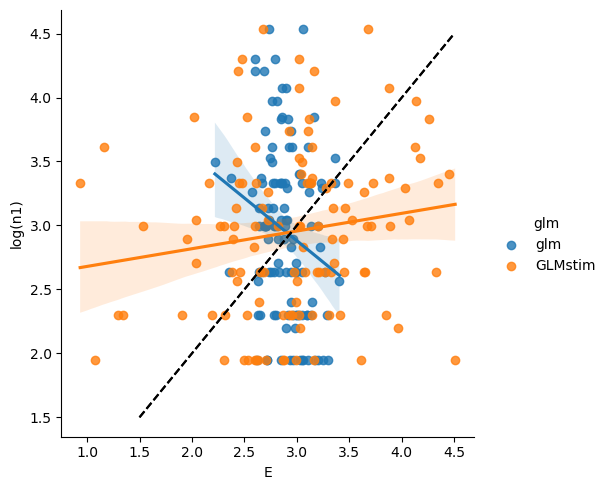

In [ ]:
tmp = pred.loc[(32, 1, 'baseline', slice(None), 'pca_confounds', slice(None), 'not smoothed', 'NPCr', 100)]

fac = sns.lmplot(x='E', y='log(n1)', data=tmp.reset_index(), hue='glm')
fac.map(lambda *args, **kwargs: plt.plot([1.5, 4.5], [1.5, 4.5], c='k', ls='--'))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


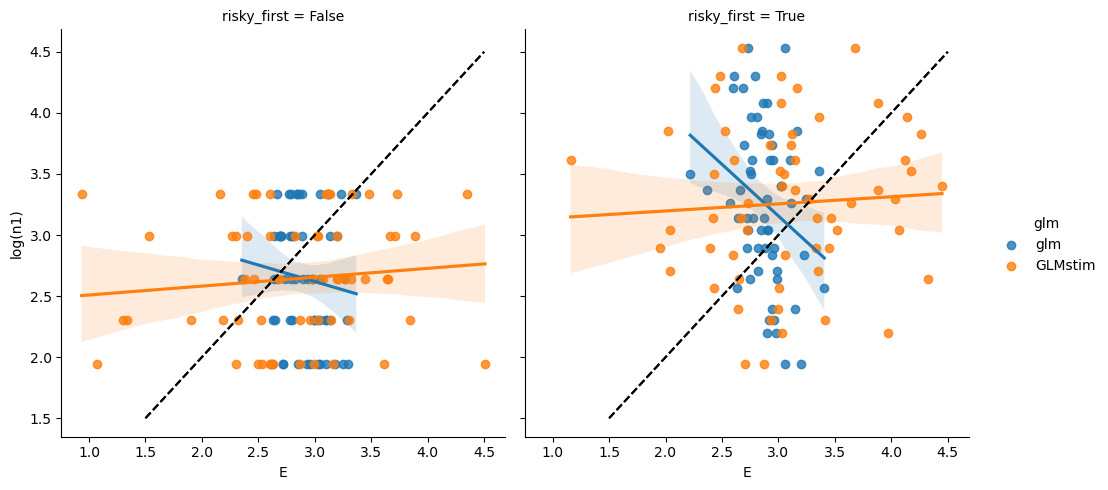

In [ ]:
tmp = pred.loc[(32, 1, 'baseline', slice(None), 'pca_confounds', slice(None), 'not smoothed', 'NPCr', 100)]

fac = sns.lmplot(x='E', y='log(n1)', data=tmp.reset_index(), hue='glm', col='risky_first')
fac.map(lambda *args, **kwargs: plt.plot([1.5, 4.5], [1.5, 4.5], c='k', ls='--'))

<AxesSubplot: xlabel='pca-glm-smoothed-mask-n_voxels', ylabel='pca-glm-smoothed-mask-n_voxels'>

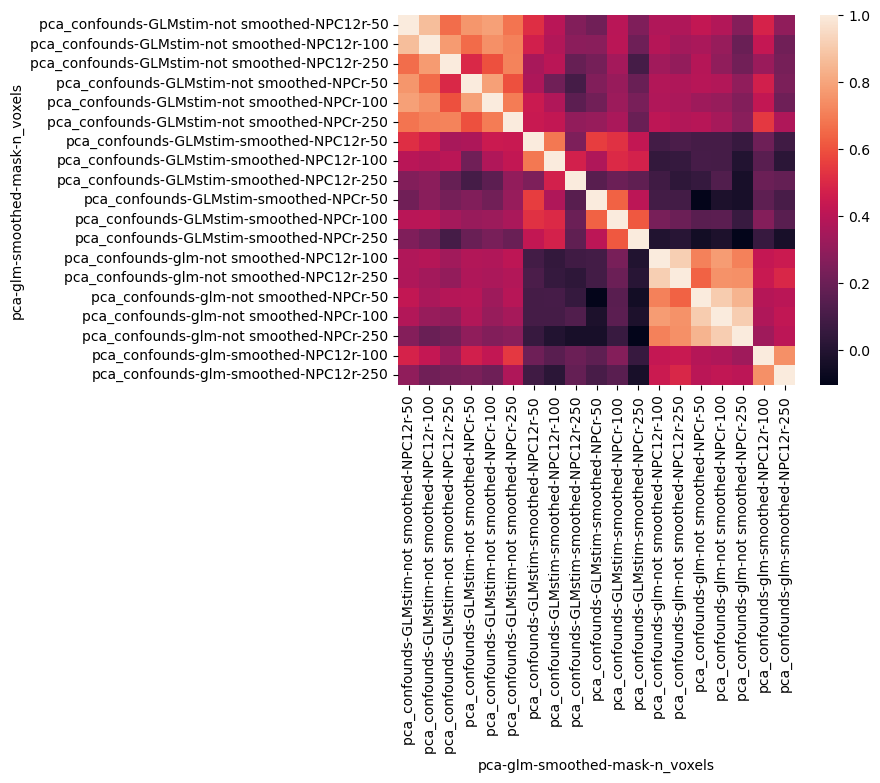

In [ ]:
sns.heatmap(r2.unstack([1, 2, 3, 4, 5])['r'].corr())

In [ ]:
import arviz as az

In [ ]:
from tms_risk.cogmodels.fit_probit import build_model

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
import scipy.stats as ss
def invprobit(x):
    return ss.norm.ppf(x)

def extract_rnp_precision(trace, model, data, group=False):

    data = data.reset_index()

    if group:
        fake_data = pd.MultiIndex.from_product([data.reset_index()['subject'].unique()[[0]],
                                                [0, 1],
                                                data['n_safe'].unique(),
                                                [False, True]],
                                                names=['subject', 'x', 'n_safe', 'risky_first']
                                                ).to_frame().reset_index(drop=True)
    else:
        fake_data = pd.MultiIndex.from_product([data.reset_index()['subject'].unique(),
                                                [0, 1],
                                                data['n_safe'].unique(),
                                                [False, True]],
                                                names=['subject', 'x', 'n_safe', 'risky_first']
                                                ).to_frame().reset_index(drop=True)

    pred = model.predict(trace, 'mean', fake_data, inplace=False)['posterior']['chose_risky_mean']

    pred = pred.to_dataframe().unstack([0, 1])
    pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))

    # return pred

    pred0 = pred.xs(0, 0, 'x')
    intercept = pd.DataFrame(invprobit(pred0), index=pred0.index, columns=pred0.columns)
    gamma = invprobit(pred.xs(1, 0, 'x')) - intercept

    return intercept, gamma

In [ ]:
df = df.xs(1, 0, 'session')

df['x'] = df['log(risky/safe)']
df['chose_risky'] = df['chose_risky'].astype(bool)
df = df.reset_index()

In [ ]:
model = build_model(df=df, model_label='2')

Exception: Do not know model label 2

In [ ]:
trace = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-probit2_trace.netcdf')

In [ ]:
intercept, gamma = extract_rnp_precision(trace, model, df)

ValueError: shapes (1320,132) and (130,2000) not aligned: 132 (dim 1) != 130 (dim 0)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


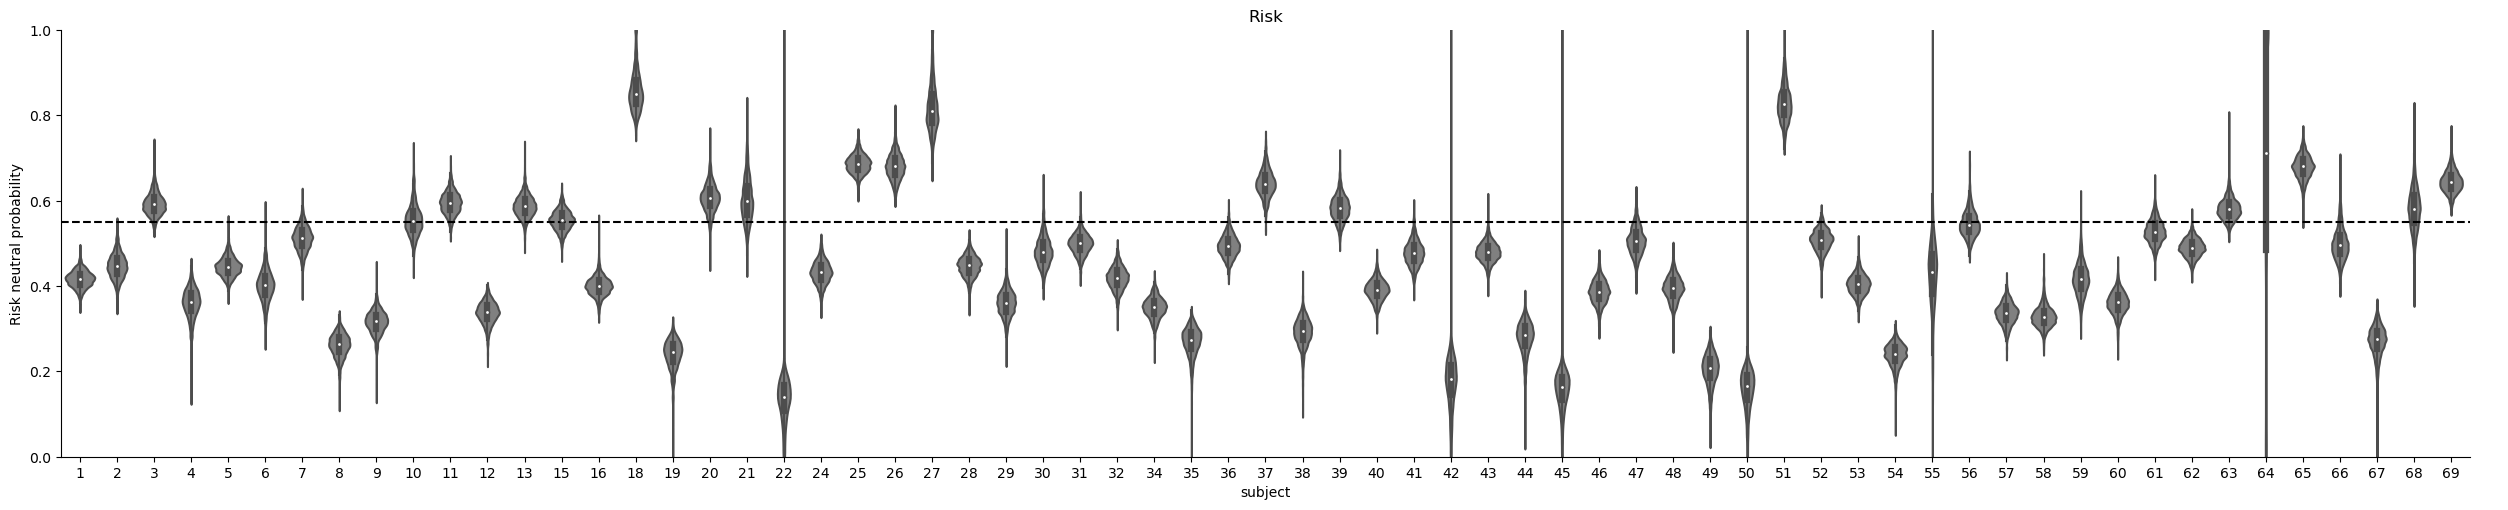

In [ ]:
import numpy as np

rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])
rnp.columns = ['rnp']

fac = sns.catplot(x='subject', y='rnp', data=rnp.reset_index(), aspect=5., kind='violin', color='gray')
plt.ylim(0, 1)
plt.axhline(.55, c='k', ls='--', label='risk-neutral')
fac.set(title='Risk', ylabel='Risk neutral probability')
fac.add_legend()

In [ ]:
r2 = r2.join(rnp.groupby('subject').mean())

In [ ]:
gamma = gamma.stack([1,2])
gamma.columns = ['gamma']

In [ ]:
r1 = r1.join(gamma.groupby('subject').mean())

In [ ]:
r = r1.groupby(['pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['gamma']))

r['r'].unstack(['mask', 'glm']).droplevel(-1, axis=0)

mask                                   NPC12r      NPCr    NPC12r      NPCr
glm                                   GLMstim   GLMstim       glm       glm
pca           smoothed     n_voxels                                        
pca_confounds not smoothed 50        0.306035  0.365903       NaN  0.242793
                           100       0.176997  0.311680  0.189537  0.301513
                           250       0.149224  0.071740  0.204035  0.284374
              smoothed     50        0.165939  0.064851       NaN       NaN
                           100       0.076006  0.018013  0.091756       NaN
                           250       0.107457  0.180349  0.183288       NaN

In [ ]:
trace = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-2_trace.netcdf')

NameError: name 'az' is not defined

In [ ]:
evidence_sd = trace.posterior['evidence_sd'].to_dataframe().unstack('presentation').groupby('subject').mean()

In [ ]:
r1 = r1.join(evidence_sd)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33795/2619899885.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  r1 = r1.join(evidence_sd)


In [ ]:
r2 = r2.join(evidence_sd)

NameError: name 'evidence_sd' is not defined

In [ ]:
r = r2.groupby(['pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d[('evidence_sd', 'first')]))

r['r'].unstack(['mask', 'glm']).droplevel(-1, axis=0)

KeyError: ('evidence_sd', 'first')

In [ ]:
r = r1.groupby(['pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d[('evidence_sd', 'second')]))

r['r'].unstack(['mask', 'glm']).droplevel(-1, axis=0)

mask                                   NPC12r      NPCr    NPC12r      NPCr
glm                                   GLMstim   GLMstim       glm       glm
pca           smoothed     n_voxels                                        
pca_confounds not smoothed 50       -0.285383 -0.375604       NaN -0.109276
                           100      -0.105104 -0.318362  0.006999 -0.133332
                           250       0.106068 -0.001819  0.050335 -0.101337
              smoothed     50       -0.116371 -0.132375       NaN       NaN
                           100      -0.049254 -0.121099  0.043080       NaN
                           250      -0.127178 -0.073383  0.114014       NaN

In [ ]:
sns.scatterplot(rnp.groupby('subject').mean().join(evidence_sd), x=('evidence_sd', 'second'),
 y='rnp')

plt.axhline(0.55, c='k', ls='--')

NameError: name 'rnp' is not defined